In [1]:
""" 데이터 셋 불러오기 """
import os
import struct
import numpy as np

def load_mnist(path, kind = 'train') :
    """ 'path'에서 MNIST 데이터 불러오기 """
    labels_path = os.path.join(path, '%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images.idx3-ubyte' % kind)
    
    with open(labels_path, 'rb') as lbpath :
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype = np.uint8)
    
    with open(images_path, 'rb') as imgpath : 
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype = np.uint8).reshape(len(labels), 784)
        images = ((images / 255.) - .5) * 2
    
    return images, labels

In [2]:
# Data 적재
X_data, y_data = load_mnist('../Dataset/', kind = 'train')
print('행 : %d, 열 : %d' % (X_data.shape[0], X_data.shape[1]))

X_test, y_test = load_mnist('../Dataset/', kind = 't10k')
print('행 : %d, 열 : %d' % (X_test.shape[0], X_test.shape[1]))

X_train, y_train = X_data[:50000, :], y_data[:50000]
X_valid, y_valid = X_data[50000:, :], y_data[50000:]

print('훈련 세트 : ', X_train.shape, y_train.shape)
print('검증 세트 : ', X_valid.shape, y_valid.shape)
print('테스트 세트 : ', X_test.shape, y_test.shape)

행 : 60000, 열 : 784
행 : 10000, 열 : 784
훈련 세트 :  (50000, 784) (50000,)
검증 세트 :  (10000, 784) (10000,)
테스트 세트 :  (10000, 784) (10000,)


In [3]:
# Preprocessing
mean_vals = np.mean(X_train, axis = 0)
std_val = np.std(X_train)
# 특성별 표준편차는 흰색 배경에 의해 계산하지 않는다.
X_train_centered = (X_train - mean_vals) / std_val
X_valid_centered = (X_valid - mean_vals) / std_val
X_test_centered = (X_test - mean_vals) / std_val

In [4]:
# Input 형태 맞추기
# 합성곱 신경망에는 채널이 필요하기 때문
X_train_centered = X_train_centered.reshape((-1, 28, 28, 1))
X_valid_centered = X_valid_centered.reshape((-1, 28, 28, 1))
X_test_centered = X_test_centered.reshape((-1, 28, 28, 1))

In [5]:
# 원-핫 인코딩
from tensorflow.keras.utils import to_categorical

y_train_onehot = to_categorical(y_train)
y_valid_onehot = to_categorical(y_valid)
y_test_onehot = to_categorical(y_test)

print(y_train[0], y_train_onehot[0])

5 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


In [6]:
print('훈련 세트 : ', X_train_centered.shape, y_train_onehot.shape)
print('검증 세트 : ', X_valid_centered.shape, y_valid_onehot.shape)
print('테스트 세트 : ', X_test_centered.shape, y_test_onehot.shape)

훈련 세트 :  (50000, 28, 28, 1) (50000, 10)
검증 세트 :  (10000, 28, 28, 1) (10000, 10)
테스트 세트 :  (10000, 28, 28, 1) (10000, 10)


In [7]:
# CNN 구성
from tensorflow.keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(32, (5, 5), padding = 'valid', activation = 'relu', input_shape = (28, 28, 1)))
# 5*5 크기의 필터 32개, s = 1 (기본값)
# 특성 맵 크기 = 24 * 24 * 32, 가중치 개수 5*5*32 + 32
model.add(layers.MaxPool2D(2, 2))
# 12 * 12 * 32
model.add(layers.Conv2D(64, (5, 5), padding = 'valid', activation = 'relu'))
# 8 * 8 * 64, 필터 크기는 5 * 5 * 32
model.add(layers.MaxPool2D((2, 2)))
# 4 * 4 * 64
model.add(layers.Flatten())
# 1024 dim
model.add(layers.Dense(1024, activation = 'relu'))
# 가중치 1024 * 1024 + 1024
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation = 'softmax'))
# 가중치 1024 * 10 + 10

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0

In [8]:
# 컴파일
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['acc'])

In [19]:

import time
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

callback_list = [ModelCheckpoint(filepath = 'cnn_checkpoint.h5', 
                                 monitor = 'val_loss', 
                                 save_best_only=True)]

print("logs/{}".format(time.strftime('%I-%M-%S %p', time.localtime())))

logs/04-00-32 PM


In [20]:
# 훈련
history = model.fit(X_train_centered, y_train_onehot, 
                    batch_size = 64, epochs = 20, 
                    validation_data = (X_valid_centered, y_valid_onehot),
                    callbacks = callback_list)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 26s 511us/sample - loss: 0.1260 - acc: 0.9621 - val_loss: 0.0515 - val_acc: 0.9848
Epoch 2/20
50000/50000 [==============================] - 39s 785us/sample - loss: 0.0491 - acc: 0.9848 - val_loss: 0.0466 - val_acc: 0.9884
Epoch 3/20
50000/50000 [==============================] - 53s 1ms/sample - loss: 0.0370 - acc: 0.9884 - val_loss: 0.0372 - val_acc: 0.9895
Epoch 4/20
50000/50000 [==============================] - 62s 1ms/sample - loss: 0.0268 - acc: 0.9917 - val_loss: 0.0367 - val_acc: 0.9922
Epoch 5/20
50000/50000 [==============================] - 88s 2ms/sample - loss: 0.0260 - acc: 0.9922 - val_loss: 0.0379 - val_acc: 0.9902
Epoch 6/20
50000/50000 [==============================] - 110s 2ms/sample - loss: 0.0183 - acc: 0.9941 - val_loss: 0.0340 - val_acc: 0.9915
Epoch 7/20
50000/50000 [==============================] - 129s 3ms/sample - loss: 0.0173 - acc: 0.9943 - val_lo

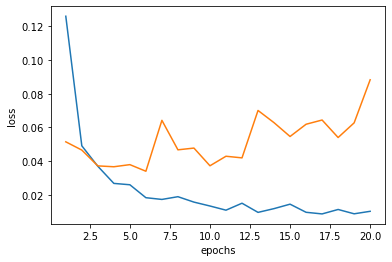

In [21]:
# 손실 그래프
import matplotlib.pyplot as plt

epochs = np.arange(1, 21)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

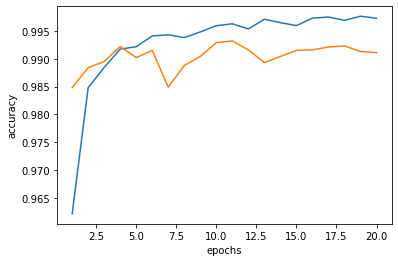

In [22]:
# 정확도 그래프

plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

In [23]:
# 모델 저장

model.save('cnn_model.h5')

In [24]:
# 불러오기
from tensorflow.keras.models import load_model

restored_model = load_model('cnn_model.h5')
restored_model.load_weights('cnn_checkpoint.h5')

In [25]:
# 불러온 모델로 평가

restored_model.evaluate(X_test_centered, y_test_onehot)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.026641974791967324, 0.9912]

In [28]:
# 확인

np.argmax(restored_model.predict(X_test_centered[:10]), axis = 1)

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=int64)

In [29]:
# 검증

y_test[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9], dtype=uint8)

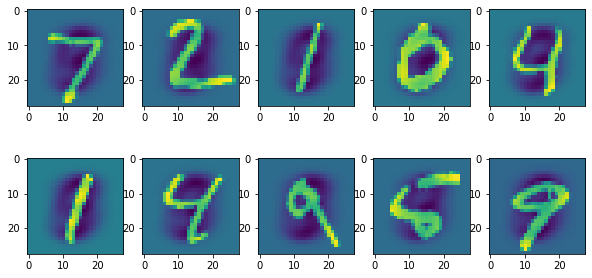

In [30]:
# 그림 확인

fig = plt.figure(figsize = (10, 5))
for i in range(10) : 
    fig.add_subplot(2, 5, i + 1)
    plt.imshow(X_test_centered[i].reshape(28, 28))

In [31]:
# 활성화 출력과 필터 시각화

first_layer = model.layers[0]
print(first_layer)

In [32]:
print(model.input)

Tensor("conv2d_input:0", shape=(None, 28, 28, 1), dtype=float32)


In [33]:
first_activation = models.Model(inputs = model.input,
                               outputs = first_layer.output)
activation = first_activation.predict(X_test_centered[:10])

In [34]:
print(activation.shape)

(10, 24, 24, 32)


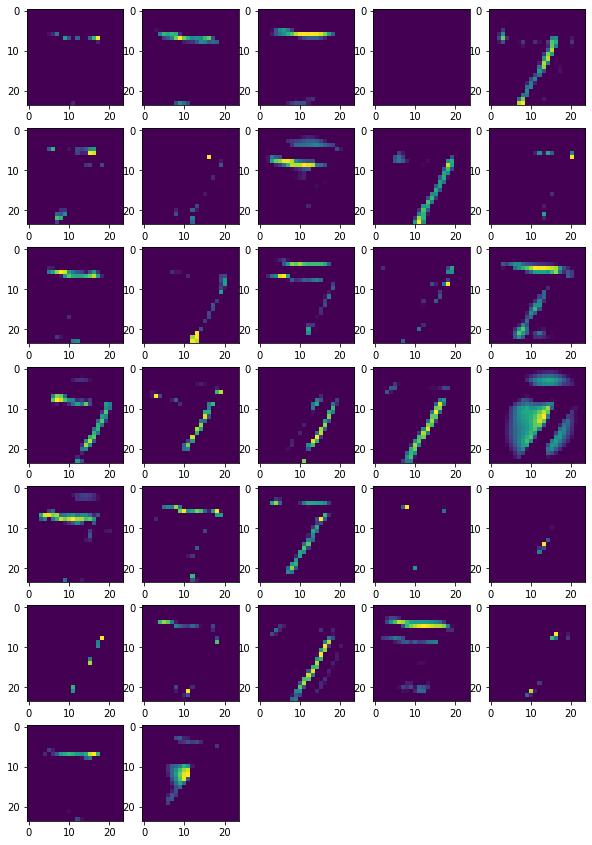

In [35]:
# 특성 맵 그리기

fig = plt.figure(figsize = (10, 15))
for i in range(32) : 
    fig.add_subplot(7, 5, i + 1)
    plt.imshow(activation[0, :, :, i])

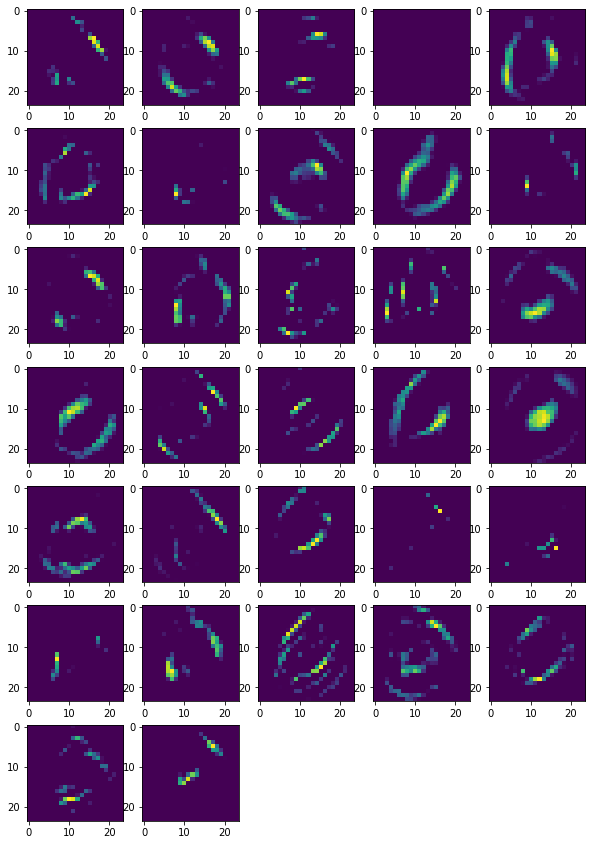

In [36]:
fig # 특성 맵 그리기

fig = plt.figure(figsize = (10, 15))
for i in range(32) : 
    fig.add_subplot(7, 5, i + 1)
    plt.imshow(activation[3, :, :, i])

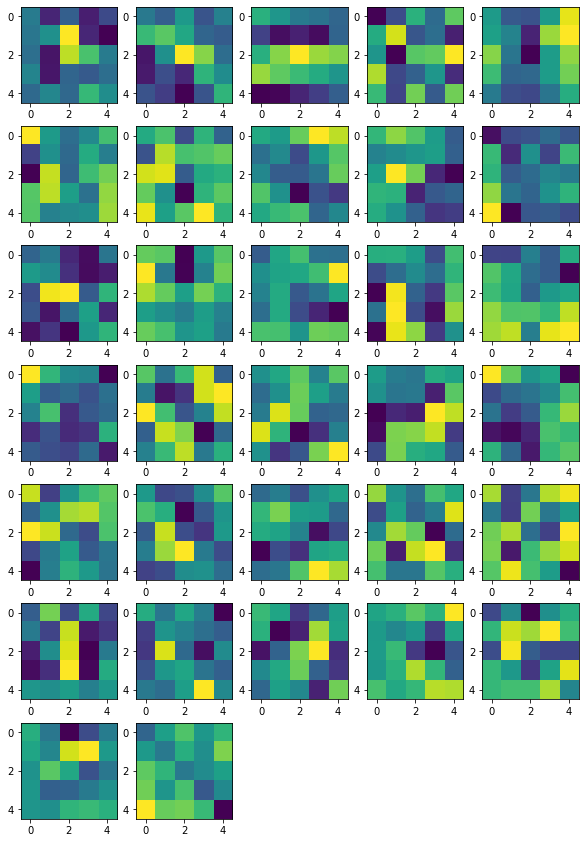

In [37]:
# 첫 번째 층 필터 출력
# 특성 맵 그리기

fig = plt.figure(figsize = (10, 15))
for i in range(32) : 
    fig.add_subplot(7, 5, i + 1)
    plt.imshow(first_layer.kernel[:, :, 0, i])